In [3]:
import pandas as pd 
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [5]:
df = pd.read_csv('IMDB Dataset.csv')
df.isnull().values.any()
df.shape

(50000, 2)

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df['review'][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

<Axes: xlabel='sentiment', ylabel='count'>

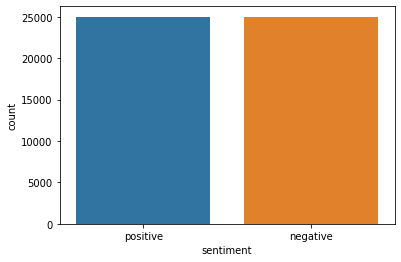

In [9]:
import seaborn as sns

sns.countplot(x='sentiment', data=df)

In [10]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [11]:
def preprocess_text(sen):
    sentance = remove_tags(sen)
    sentance = re.sub('[^a-zA-Z]', ' ', sentance)
    sentance = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentance)
    sentance = re.sub(r'\s+', ' ', sentance)
    return sentance


In [12]:
x = []
sentences = list(df['review'])
for sen in sentences:
    x.append(preprocess_text(sen))
    

In [13]:
x[2]


'I thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy The plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer While some may be disappointed when they realize this is not Match Point Risk Addiction thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love This was the most d laughed at one of Woody comedies in years dare say decade While ve never been impressed with Scarlet Johanson in this she managed to tone down her sexy image and jumped right into average but spirited young woman This may not be the crown jewel of his career but it was wittier than Devil Wears Prada and more interesting than Superman great comedy to go see with friends '

In [14]:
y = df['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [16]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [17]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [19]:
embedding_dict = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector = np.asarray(records[1:], dtype='float32')
    embedding_dict[word] = vector
glove_file.close()

In [20]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        

In [21]:
from keras.models import Model
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Input
import numpy as np

model = Sequential()

In [22]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9254700   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9318957 (35.55 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9254700 (35.30 MB)
_________________________________________________________________


In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 6s 22ms/step - loss: 0.4939 - acc: 0.7595 - val_loss: 0.4070 - val_acc: 0.8114
Epoch 2/6
250/250 [==============================] - 5s 21ms/step - loss: 0.3678 - acc: 0.8385 - val_loss: 0.3738 - val_acc: 0.8316
Epoch 3/6
250/250 [==============================] - 5s 21ms/step - loss: 0.3172 - acc: 0.8664 - val_loss: 0.3593 - val_acc: 0.8370
Epoch 4/6
250/250 [==============================] - 5s 22ms/step - loss: 0.2761 - acc: 0.8886 - val_loss: 0.3522 - val_acc: 0.8432
Epoch 5/6
250/250 [==============================] - 6s 22ms/step - loss: 0.2439 - acc: 0.9055 - val_loss: 0.3440 - val_acc: 0.8439
Epoch 6/6
313/313 [==============================] - 1s 3ms/step - loss: 0.3445 - acc: 0.8480


In [25]:
print("Test Score:", score[0])

print("Test Accuracy:", score[1])


Test Score: 0.34449389576911926
Test Accuracy: 0.8479999899864197


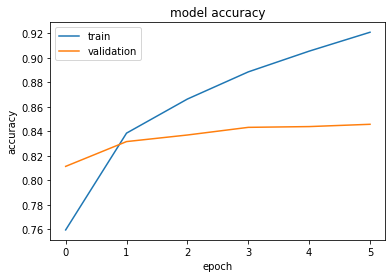

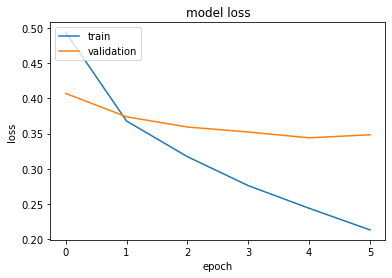

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [67]:
# Test that the model works
test_data = ['This movie is fantastic! I really like it because it is so good!', 'This movie is bad! I really hate it because it is so bad!', 'This movie is ok! I really like it because it is so good!']
test = tokenizer.texts_to_sequences(test_data)
test = pad_sequences(test, padding='post', maxlen=maxlen)

model.predict(test)


1/1 [==============================] - 0s 12ms/step


array([[0.99935323],
       [0.02551755],
       [0.94191   ]], dtype=float32)